In [17]:
import sys
sys.path.append('/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start')
from my_functions import *
del anim_singletime_var

In [34]:
def loadPref_nc_file(i_t, df):
    prec = loadPrec(i_t, df)

    # Get the timestamp from the file name
    file_name = df.loc[i_t, 'path_dyamond']
    timestamp = file_name[35:45]

    # Specify the output file path and name
    output_file = f"DYAMOND_9216x4608x74_7.5s_4km_4608_{timestamp}.Prec_calculated.2D.nc"

    # Create a new NetCDF dataset
    dataset = netCDF4.Dataset(output_file, mode="w", format="NETCDF4")

    # Define dimensions
    lat_dim = dataset.createDimension("lat", size=prec.shape[0])
    lon_dim = dataset.createDimension("lon", size=prec.shape[1])

    # Create variables
    lat_var = dataset.createVariable("lat", "f4", dimensions=("lat",))
    lon_var = dataset.createVariable("lon", "f4", dimensions=("lon",))
    prec_var = dataset.createVariable("prec", "f4", dimensions=("lat", "lon"))

    # Assign values to variables
    lat_var[:] = prec.lat.values
    lon_var[:] = prec.lon.values
    prec_var[:] = prec.values

    # Set variable attributes
    lat_var.units = "degrees_north"
    lon_var.units = "degrees_east"
    prec_var.units = "mm"

    # Close the dataset
    dataset.close()

    return output_file

In [37]:
# test
df = loadRelTable()
i_t = 5
prec_file = loadPref_nc_file(i_t,df)

IndexError: tuple index out of range

In [40]:
# Open the netCDF file using netCDF4.Dataset
dataset = netCDF4.Dataset(prec_file)

# Access variables and attributes from the dataset
lat = dataset.variables["lat"][:]
lon = dataset.variables["lon"][:]
prec = dataset.variables["prec"][:]
units = dataset.variables["prec"].units

print(dataset.variables)
print("-------------------------------------")

# Print dimensions
print(dataset.dimensions)
print("-------------------------------------")
# Close the dataset
dataset.close()

{'lat': <class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    units: degrees_north
unlimited dimensions: 
current shape = (518,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lon': <class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    units: degrees_east
unlimited dimensions: 
current shape = (896,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'prec': <class 'netCDF4._netCDF4.Variable'>
float32 prec(lat, lon)
    units: mm
unlimited dimensions: 
current shape = (518, 896)
filling on, default _FillValue of 9.969209968386869e+36 used}
-------------------------------------
{'lat': <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 518, 'lon': <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 896}
-------------------------------------


# This one is good for any variable that is not Precac

In [5]:
def anim_singletime_var(variable: str, timestamps: list = None, desired_duration: int = 20, video_path: str = 'output_video.mp4'):
    name_dict = {"OM500":"Pressure velocity at 500 mb", "T2mm":"2-m temperature", "OM850":"Pressure velocity at 850 mb", "Precac":"Surface Accum Precip.", "PW":"Precipitable Water", "CWP":"Cloud Water Path", "U10m":"10-m zonal wind", "RH500":"Relative Humidity 500mb", "PSFC":"P at the surface","V10m":"10-m meridional wind","SHF":"Sensible Heat Flux", "LHF":"Latent Heat Flux"}
    unit_dict = {"OM500":"Pa/s","T2mm":"K", "OM850":"Pa/s","Precac":"mm", "PW":"kg/m²", "CWP":"kg/m²", "U10m":"m/s", "RH500":"", "PSFC":"mbar", "V10m":"m/s","SHF":"W/m²", "LHF":"W/m²"}
        
    # Search for files containing the desired characters
    matching_files = glob.glob(path_2D + '/*{}*'.format(variable))
    sorted_files = sorted(matching_files)

    # Use all available timestamps if none are provided
    if timestamps is None:
        timestamps = get_timestamps(sorted_files, 119, 129)

    # Get the overall minimum and maximum values of variable_data
    min_value = float('inf')
    max_value = float('-inf')

    # Calculate the overall minimum and maximum values
    for timestamp in timestamps:
        i_t = find_file_with_string(sorted_files, timestamp, 119, 129)
        file = sorted_files[i_t]
        dataset = netCDF4.Dataset(file)

        variable_data = dataset.variables[variable][:]
        min_value = min(min_value, variable_data.min())
        max_value = max(max_value, variable_data.max())

    # Create a list to store the frames for the video
    frames = []

    # Generate plots for each timestamp with a progress bar
    with tqdm(total=len(timestamps), desc='Generating Frames') as pbar:
        for timestamp in timestamps:
            i_t = find_file_with_string(sorted_files, timestamp, 119, 129)
            file = sorted_files[i_t]
            dataset = netCDF4.Dataset(file)

            # Getting data
            variable_data = dataset.variables[variable][:]
            # Get the lon and lat values
            lon = dataset.variables['lon'][:]
            lat = dataset.variables['lat'][:]

            # Plot the variable
            fig, ax = plt.subplots()
            
            img = ax.imshow(variable_data[0, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()])

            plt.xlabel('Longitude (° East)')
            plt.ylabel('Latitude (° North)')
            title = f"DYAMOND SAM {name_dict.get(variable)}\nTime Stamp: {timestamp}"
            plt.title(title)
            # ax.grid(True, linestyle='--', linewidth=0.5, color='white', alpha=0.5)
            if variable == "RH500":
                cbar = plt.colorbar(img)  # Use the variable im here to create the colorbar
            else:
                cbar = plt.colorbar(img, label=unit_dict.get(variable))  # Use the variable im here to create the colorbar
            
            

            # Set consistent colorbar limits
            img.set_clim(min_value, max_value)

            # Convert the plot to an image frame
            fig.canvas.draw()
            frame = np.array(fig.canvas.renderer._renderer)
            frames.append(frame)

            plt.close(fig)

            # Update the progress bar
            pbar.set_postfix({'Timestamp': timestamp})
            pbar.update(1)

    # Calculate the desired fps based on the desired duration
    num_frames = len(frames)
    fps = math.ceil(num_frames / desired_duration)

    # Save the frames as a video with the desired fps
    imageio.mimsave(video_path, frames, fps=fps)

    print(f'Video saved to: {video_path}')


In [ ]:
anim_singletime_var(variable="OM500", video_path="OM500_test1.mp4")

Generating Frames: 100%|███████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.17it/s, Timestamp=0000460800]


Video saved to: OM500_test1.mp4


# Trying to edit the above for Precac

## test 1

In [55]:
def anim_singletime_var_Precac(variable: str, timestamps: list = None, desired_duration: int = 20, video_path: str = 'output_video.mp4'):
    name_dict = {"OM500":"Pressure velocity at 500 mb", "T2mm":"2-m temperature", "OM850":"Pressure velocity at 850 mb", "Precac":"Surface Accum Precip.", "PW":"Precipitable Water", "CWP":"Cloud Water Path", "U10m":"10-m zonal wind", "RH500":"Relative Humidity 500mb", "PSFC":"P at the surface","V10m":"10-m meridional wind","SHF":"Sensible Heat Flux", "LHF":"Latent Heat Flux"}
    unit_dict = {"OM500":"Pa/s","T2mm":"K", "OM850":"Pa/s","Precac":"mm", "PW":"kg/m²", "CWP":"kg/m²", "U10m":"m/s", "RH500":"", "PSFC":"mbar", "V10m":"m/s","SHF":"W/m²", "LHF":"W/m²"}

    ### edit
    min_value = float('inf')
    max_value = float('-inf')
    
    if variable == "Precac":
        df = loadRelTable() # load relation table
        # Use all available timestamps if none are provided
        if timestamps is None:
            sorted_files = df['path_dyamond'].tolist()
            timestamps = get_timestamps(sorted_files, 35, 45) # 35 to 45 are the timestamp string characters
            
        for timestamp in timestamps:
            seg_index = timestamp_to_seg_index(timestamp)
            if seg_index == 0:
                seg_index = 1
                print("i_t:", seg_index)
            prec = loadPrec(seg_index, df)
            prec_filename = loadPrecacFilename(seg_index, df)
            
            # Replace negative values with NaN
            prec = xr.where(prec < 0, np.nan, prec)
            variable_data = prec.values
            lon = prec.lon.values
            lat = prec.lat.values
            min_value = min(min_value, variable_data.min())
            max_value = max(max_value, variable_data.max())

    else:
        # Search for files containing the desired characters
        matching_files = glob.glob(path_2D + '/*{}*'.format(variable))
        sorted_files = sorted(matching_files)

        # Use all available timestamps if none are provided
        if timestamps is None:
            timestamps = get_timestamps(sorted_files, 119, 129)

        # Get the overall minimum and maximum values of variable_data


        # Calculate the overall minimum and maximum values
        for timestamp in timestamps:
            i_t = find_file_with_string(sorted_files, timestamp, 119, 129)
            file = sorted_files[i_t]
            dataset = netCDF4.Dataset(file)

            variable_data = dataset.variables[variable][:]
            min_value = min(min_value, variable_data.min())
            max_value = max(max_value, variable_data.max())
    ### edit

    # Create a list to store the frames for the video
    frames = []

    # Generate plots for each timestamp with a progress bar
    with tqdm(total=len(timestamps), desc='Generating Frames') as pbar:
        for timestamp in timestamps:
            if variable == "Precac":
                df = loadRelTable() # load relation table
                # Use all available timestamps if none are provided
                if timestamps is None:
                    sorted_files = df['path_dyamond'].tolist()
                    timestamps = get_timestamps(sorted_files, 35, 45) # 35 to 45 are the timestamp string characters

                for timestamp in timestamps:
                    seg_index = timestamp_to_seg_index(timestamp)
                    if seg_index == 0:
                        seg_index = 1
                        print("i_t:", seg_index)
                    prec = loadPrec(seg_index, df)
                    prec_filename = loadPrecacFilename(seg_index, df)

                    # Replace negative values with NaN
                    prec = xr.where(prec < 0, np.nan, prec)
                    variable_data = prec.values
                    lon = prec.lon.values
                    lat = prec.lat.values
            else:
                i_t = find_file_with_string(sorted_files, timestamp, 119, 129)
                file = sorted_files[i_t]
                dataset = netCDF4.Dataset(file)

                # Getting data
                variable_data = dataset.variables[variable][:]
                # Get the lon and lat values
                lon = dataset.variables['lon'][:]
                lat = dataset.variables['lat'][:]

            # Plot the variable
            print(variable_data.shape)
            fig, ax = plt.subplots()
            
            if variable == "Precac":
                img = ax.imshow(variable_data, origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()])
            else:
                img = ax.imshow(variable_data[0, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()])
            plt.xlabel('Longitude (° East)')
            plt.ylabel('Latitude (° North)')
            title = f"DYAMOND SAM {name_dict.get(variable)}\nTime Stamp: {timestamp}"
            plt.title(title)
            # ax.grid(True, linestyle='--', linewidth=0.5, color='white', alpha=0.5)
            if variable == "RH500":
                cbar = plt.colorbar(img)  # Use the variable im here to create the colorbar
            else:
                cbar = plt.colorbar(img, label=unit_dict.get(variable))  # Use the variable im here to create the colorbar
            
            

            # Set consistent colorbar limits
            img.set_clim(min_value, max_value)

            # Convert the plot to an image frame
            fig.canvas.draw()
            frame = np.array(fig.canvas.renderer._renderer)
            frames.append(frame)

            plt.close(fig)

            # Update the progress bar
            pbar.set_postfix({'Timestamp': timestamp})
            pbar.update(1)

    # Calculate the desired fps based on the desired duration
    num_frames = len(frames)
    fps = math.ceil(num_frames / desired_duration)

    # Save the frames as a video with the desired fps
    imageio.mimsave(video_path, frames, fps=fps)

    print(f'Video saved to: {video_path}')


In [56]:
anim_singletime_var_Precac(variable="Precac", timestamps=["0000001200", "0000001440", "0000001680"], video_path="prec_test1.mp4")

Generating Frames:  33%|███████████████████████▋                                               | 1/3 [00:01<00:03,  1.53s/it, Timestamp=0000001680]

(518, 896)


Generating Frames:  67%|███████████████████████████████████████████████▎                       | 2/3 [00:03<00:01,  1.52s/it, Timestamp=0000001680]

(518, 896)


Generating Frames: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.52s/it, Timestamp=0000001680]

(518, 896)


Generating Frames: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.52s/it, Timestamp=0000001680]

Video saved to: prec_test1.mp4


## test 2
* this one works when I feed it a list of three timestamps that are in the middle
* this one is not log scale

In [107]:
def anim_singletime_var_Precac(variable: str, timestamps: list = None, desired_duration: int = 20, video_path: str = 'output_video.mp4'):
    name_dict = {"OM500": "Pressure velocity at 500 mb", "T2mm": "2-m temperature", "OM850": "Pressure velocity at 850 mb", "Precac": "Surface Accum Precip.", "PW": "Precipitable Water", "CWP": "Cloud Water Path", "U10m": "10-m zonal wind", "RH500": "Relative Humidity 500mb", "PSFC": "P at the surface", "V10m": "10-m meridional wind", "SHF": "Sensible Heat Flux", "LHF": "Latent Heat Flux"}
    unit_dict = {"OM500": "Pa/s", "T2mm": "K", "OM850": "Pa/s", "Precac": "mm", "PW": "kg/m²", "CWP": "kg/m²", "U10m": "m/s", "RH500": "", "PSFC": "mbar", "V10m": "m/s", "SHF": "W/m²", "LHF": "W/m²"}

    min_value = float('inf')
    max_value = float('-inf')

    if variable == "Precac":
        df = loadRelTable() # load relation table

        if timestamps is None:
            sorted_files = df['path_dyamond'].tolist()
            timestamps = get_timestamps(sorted_files, 35, 45)

        for timestamp in timestamps:
            seg_index = timestamp_to_seg_index(timestamp)
            if seg_index == 0:
                seg_index = 1
                print("i_t:", seg_index)
            prec = loadPrec(seg_index, df)
            prec_filename = loadPrecacFilename(seg_index, df)

            # Replace negative values with NaN
            prec = xr.where(prec < 0, np.nan, prec)
            variable_data = prec.values
            lon = prec.lon.values
            lat = prec.lat.values
            min_value = min(min_value, variable_data.min())
            max_value = max(max_value, variable_data.max())

    else:
        matching_files = glob.glob(path_2D + '/*{}*'.format(variable))
        sorted_files = sorted(matching_files)

        if timestamps is None:
            timestamps = get_timestamps(sorted_files, 119, 129)

        for timestamp in timestamps:
            i_t = find_file_with_string(sorted_files, timestamp, 119, 129)
            file = sorted_files[i_t]
            dataset = netCDF4.Dataset(file)

            variable_data = dataset.variables[variable][:]
            min_value = min(min_value, variable_data.min())
            max_value = max(max_value, variable_data.max())

    frames = []

    with tqdm(total=len(timestamps), desc='Generating Frames') as pbar:
        for timestamp in timestamps:
            if variable == "Precac":
                df = loadRelTable() # load relation table

                if timestamps is None:
                    sorted_files = df['path_dyamond'].tolist()
                    timestamps = get_timestamps(sorted_files, 35, 45)

                seg_index = timestamp_to_seg_index(timestamp)
                if seg_index == 0:
                    seg_index = 1
                    print("i_t:", seg_index)
                prec = loadPrec(seg_index, df)
                prec_filename = loadPrecacFilename(seg_index, df)

                # Replace negative values with NaN
                prec = xr.where(prec < 0, np.nan, prec)
                variable_data = prec.values
                lon = prec.lon.values
                lat = prec.lat.values
            else:
                i_t = find_file_with_string(sorted_files, timestamp, 119, 129)
                file = sorted_files[i_t]
                dataset = netCDF4.Dataset(file)

                # Getting data
                variable_data = dataset.variables[variable][:]
                # Get the lon and lat values
                lon = dataset.variables['lon'][:]
                lat = dataset.variables['lat'][:]

            fig, ax = plt.subplots()

            if variable == "Precac":
                img = ax.imshow(variable_data, origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()])
            else:
                img = ax.imshow(variable_data[0, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()])
            plt.xlabel('Longitude (° East)')
            plt.ylabel('Latitude (° North)')
            title = f"DYAMOND SAM {name_dict.get(variable)}\nTime Stamp: {timestamp}"
            plt.title(title)
            
            if variable == "RH500":
                cbar = plt.colorbar(img)
            else:
                cbar = plt.colorbar(img, label=unit_dict.get(variable))

            img.set_clim(min_value, max_value)

            fig.canvas.draw()
            frame = np.array(fig.canvas.renderer._renderer)
            frames.append(frame)

            plt.close(fig)

            pbar.set_postfix({'Timestamp': timestamp})
            pbar.update(1)

    num_frames = len(frames)
    fps = math.ceil(num_frames / desired_duration)

    imageio.mimsave(video_path, frames, fps=fps)

    print(f'Video saved to: {video_path}')


In [108]:
anim_singletime_var_Precac(variable="Precac", timestamps=["0000001200", "0000001440", "0000001680"], video_path="prec_test2.mp4")

Generating Frames: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.47it/s, Timestamp=0000001680]

Video saved to: prec_test2.mp4


## test 3

In [115]:
import math
import matplotlib.pyplot as plt
import numpy as np
import imageio
from matplotlib.colors import LogNorm
from tqdm import tqdm

def anim_singletime_var_Precac(variable: str, timestamps: list = None, desired_duration: int = 20, video_path: str = 'output_video.mp4'):
    name_dict = {"OM500": "Pressure velocity at 500 mb", "T2mm": "2-m temperature", "OM850": "Pressure velocity at 850 mb", "Precac": "Surface Accum Precip.", "PW": "Precipitable Water", "CWP": "Cloud Water Path", "U10m": "10-m zonal wind", "RH500": "Relative Humidity 500mb", "PSFC": "P at the surface", "V10m": "10-m meridional wind", "SHF": "Sensible Heat Flux", "LHF": "Latent Heat Flux"}
    unit_dict = {"OM500": "Pa/s", "T2mm": "K", "OM850": "Pa/s", "Precac": "mm", "PW": "kg/m²", "CWP": "kg/m²", "U10m": "m/s", "RH500": "", "PSFC": "mbar", "V10m": "m/s", "SHF": "W/m²", "LHF": "W/m²"}

    frames = []
    min_value = float('inf')
    max_value = float('-inf')

    with tqdm(total=len(timestamps), desc='Generating Frames') as pbar:
        for timestamp in timestamps:
            if variable == "Precac":
                seg_index = timestamp_to_seg_index(timestamp)
                print("i_t:", seg_index)
                df = loadRelTable()
                if seg_index == 0:
                    seg_index = 1
                prec = loadPrec(seg_index, df)
                prec_filename = loadPrecacFilename(seg_index, df)

                # Replace negative values with NaN
                prec = xr.where(prec < 0, np.nan, prec)

                variable_data = prec.values
                lon = prec.lon.values
                lat = prec.lat.values
                fig, ax = plt.subplots()

                # Apply logarithmic scaling for positive values
                positive_data = np.where(variable_data > 0, np.log(variable_data), 0)
                # Plot the variable data
                im = ax.imshow(positive_data, origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], norm=LogNorm(vmin=0.0001))

                # Compute vmin and vmax based on non-NaN values
                valid_values = positive_data[~np.isnan(positive_data)]
                vmin = np.min(valid_values)
                vmax = np.max(valid_values)

            else:
                # Rest of the code...
                matching_files = glob.glob(path_2D + '/*{}*'.format(variable))
                sorted_files = sorted(matching_files)
                i_t = find_file_with_string(sorted_files, timestamp, 119, 129)  # finds index in list of files (119:129 are character indices for time stamp)

                file = sorted_files[i_t]
                dataset = netCDF4.Dataset(file)

                # Getting data
                variable_data = dataset.variables[variable][:]
                # Get the lon and lat values
                lon = dataset.variables['lon'][:]
                lat = dataset.variables['lat'][:]
                # Plot the variable data and assign it to a variable
                fig, ax = plt.subplots()
                im = ax.imshow(variable_data[0, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()])

                # Compute vmin and vmax based on the entire data range
                vmin = np.min(variable_data)
                vmax = np.max(variable_data)

            plt.xlabel('Longitude (° East)')
            plt.ylabel('Latitude (° North)')
            title = f"DYAMOND SAM {name_dict.get(variable)}\nTime Stamp: {timestamp}"
            plt.title(title)

            if variable == "RH500":
                cbar = plt.colorbar(im)  # Use the variable im here to create the colorbar
            else:
                cbar = plt.colorbar(im, label=unit_dict.get(variable))  # Use the variable im here to create the colorbar

            # Set the vmin and vmax for the colorbar
            cbar.set_clim(vmin, vmax)

            fig.canvas.draw()
            frame = np.array(fig.canvas.renderer._renderer)
            frames.append(frame)

            plt.close(fig)

            pbar.set_postfix({'Timestamp': timestamp})
            pbar.update(1)

    num_frames = len(frames)
    fps = math.ceil(num_frames / desired_duration)

    imageio.mimsave(video_path, frames, fps=fps)

    print(f'Video saved to: {video_path}')


Generating Frames:   0%|                                                                                                     | 0/3 [00:00<?, ?it/s]

i_t: 2


/tmp/ipykernel_2141888/816225681.py:36: RuntimeWarning: divide by zero encountered in log
  positive_data = np.where(variable_data > 0, np.log(variable_data), 0)
Generating Frames:   0%|                                                                                                     | 0/3 [00:00<?, ?it/s]


AttributeError: 'Colorbar' object has no attribute 'set_clim'

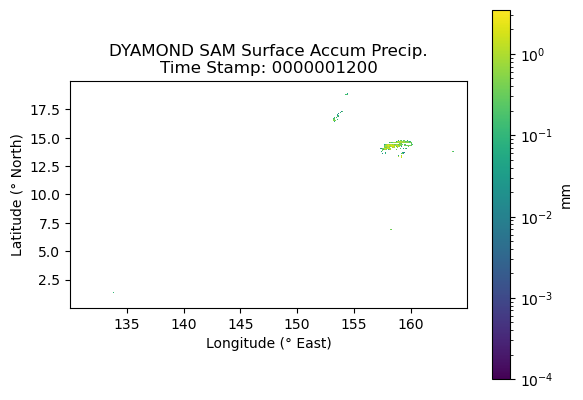

In [116]:
anim_singletime_var_Precac(variable="Precac", timestamps=["0000001200", "0000001440", "0000001680"], video_path="prec_test3.mp4")

In [119]:
# 5

In [120]:
import math
import matplotlib.pyplot as plt
import numpy as np
import imageio
from matplotlib.colors import LogNorm
from tqdm import tqdm

def anim_singletime_var_Precac(variable: str, timestamps: list = None, desired_duration: int = 20, video_path: str = 'output_video.mp4'):
    name_dict = {"OM500": "Pressure velocity at 500 mb", "T2mm": "2-m temperature", "OM850": "Pressure velocity at 850 mb", "Precac": "Surface Accum Precip.", "PW": "Precipitable Water", "CWP": "Cloud Water Path", "U10m": "10-m zonal wind", "RH500": "Relative Humidity 500mb", "PSFC": "P at the surface", "V10m": "10-m meridional wind", "SHF": "Sensible Heat Flux", "LHF": "Latent Heat Flux"}
    unit_dict = {"OM500": "Pa/s", "T2mm": "K", "OM850": "Pa/s", "Precac": "mm", "PW": "kg/m²", "CWP": "kg/m²", "U10m": "m/s", "RH500": "", "PSFC": "mbar", "V10m": "m/s", "SHF": "W/m²", "LHF": "W/m²"}

    frames = []
    min_value = float('inf')
    max_value = float('-inf')

    with tqdm(total=len(timestamps), desc='Generating Frames') as pbar:
        for timestamp in timestamps:
            if variable == "Precac":
                seg_index = timestamp_to_seg_index(timestamp)
                print("i_t:", seg_index)
                df = loadRelTable()
                if seg_index == 0:
                    seg_index = 1
                prec = loadPrec(seg_index, df)
                prec_filename = loadPrecacFilename(seg_index, df)

                # Replace negative values with NaN
                prec = xr.where(prec < 0, np.nan, prec)

                variable_data = prec.values
                lon = prec.lon.values
                lat = prec.lat.values
                fig, ax = plt.subplots()

                # Apply logarithmic scaling for positive values
                positive_data = np.where(variable_data > 0, np.log(variable_data), 0)
                # Plot the variable data
                im = ax.imshow(positive_data, origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], norm=LogNorm(vmin=0.0001))

                # Compute vmin and vmax based on non-NaN values
                valid_values = positive_data[~np.isnan(positive_data)]
                vmin = np.min(valid_values)
                vmax = np.max(valid_values)

            else:
                # Rest of the code...
                matching_files = glob.glob(path_2D + '/*{}*'.format(variable))
                sorted_files = sorted(matching_files)
                i_t = find_file_with_string(sorted_files, timestamp, 119, 129)  # finds index in list of files (119:129 are character indices for time stamp)

                file = sorted_files[i_t]
                dataset = netCDF4.Dataset(file)

                # Getting data
                variable_data = dataset.variables[variable][:]
                # Get the lon and lat values
                lon = dataset.variables['lon'][:]
                lat = dataset.variables['lat'][:]
                # Plot the variable data and assign it to a variable
                fig, ax = plt.subplots()
                im = ax.imshow(variable_data[0, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()])

                # Compute vmin and vmax based on the entire data range
                vmin = np.min(variable_data)
                vmax = np.max(variable_data)

            plt.xlabel('Longitude (° East)')
            plt.ylabel('Latitude (° North)')
            title = f"DYAMOND SAM {name_dict.get(variable)}\nTime Stamp: {timestamp}"
            plt.title(title)

            if variable == "RH500":
                cbar = plt.colorbar(im)  # Use the variable im here to create the colorbar
            else:
                cbar = plt.colorbar(im, label=unit_dict.get(variable))  # Use the variable im here to create the colorbar

            # Set the vmin and vmax for the colorbar
            im.set_clim(vmin, vmax)

            fig.canvas.draw()
            frame = np.array(fig.canvas.renderer._renderer)
            frames.append(frame)

            plt.close(fig)

            pbar.set_postfix({'Timestamp': timestamp})
            pbar.update(1)

    num_frames = len(frames)
    fps = math.ceil(num_frames / desired_duration)

    imageio.mimsave(video_path, frames, fps=fps)

    print(f'Video saved to: {video_path}')


In [121]:
anim_singletime_var_Precac(variable="Precac", timestamps=["0000001200", "0000001440", "0000001680"], video_path="prec_test3.mp4")

Generating Frames:   0%|                                                                                                     | 0/3 [00:00<?, ?it/s]

i_t: 2


/tmp/ipykernel_2141888/3838003034.py:36: RuntimeWarning: divide by zero encountered in log
  positive_data = np.where(variable_data > 0, np.log(variable_data), 0)
Generating Frames:   0%|                                                                                                     | 0/3 [00:00<?, ?it/s]


ValueError: Invalid vmin or vmax

Error in callback <function _draw_all_if_interactive at 0x7f95fe778790> (for post_execute):


ValueError: Invalid vmin or vmax

ValueError: Invalid vmin or vmax

<Figure size 640x480 with 2 Axes>

In [104]:
# 5

In [127]:
import math
import matplotlib.pyplot as plt
import numpy as np
import imageio
from matplotlib.colors import LogNorm
from tqdm import tqdm

def anim_singletime_var_Precac(variable: str, timestamps: list = None, desired_duration: int = 20, video_path: str = 'output_video.mp4'):
    name_dict = {"OM500": "Pressure velocity at 500 mb", "T2mm": "2-m temperature", "OM850": "Pressure velocity at 850 mb", "Precac": "Surface Accum Precip.", "PW": "Precipitable Water", "CWP": "Cloud Water Path", "U10m": "10-m zonal wind", "RH500": "Relative Humidity 500mb", "PSFC": "P at the surface", "V10m": "10-m meridional wind", "SHF": "Sensible Heat Flux", "LHF": "Latent Heat Flux"}
    unit_dict = {"OM500": "Pa/s", "T2mm": "K", "OM850": "Pa/s", "Precac": "mm", "PW": "kg/m²", "CWP": "kg/m²", "U10m": "m/s", "RH500": "", "PSFC": "mbar", "V10m": "m/s", "SHF": "W/m²", "LHF": "W/m²"}

    frames = []
    min_value = float('inf')
    max_value = float('-inf')
    
    ###
    if variable == "Precac":
        df = loadRelTable() # load relation table

        if timestamps is None:
            sorted_files = df['path_dyamond'].tolist()
            timestamps = get_timestamps(sorted_files, 35, 45)

        for timestamp in timestamps:
            seg_index = timestamp_to_seg_index(timestamp)
            if seg_index == 0:
                seg_index = 1
                print("i_t:", seg_index)
            prec = loadPrec(seg_index, df)
            prec_filename = loadPrecacFilename(seg_index, df)

            # Replace negative values with NaN
            prec = xr.where(prec < 0, np.nan, prec)
            variable_data = prec.values
            lon = prec.lon.values
            lat = prec.lat.values
            min_value = min(min_value, variable_data.min())
            max_value = max(max_value, variable_data.max())

    else:
        matching_files = glob.glob(path_2D + '/*{}*'.format(variable))
        sorted_files = sorted(matching_files)

        if timestamps is None:
            timestamps = get_timestamps(sorted_files, 119, 129)

        for timestamp in timestamps:
            i_t = find_file_with_string(sorted_files, timestamp, 119, 129)
            file = sorted_files[i_t]
            dataset = netCDF4.Dataset(file)

            variable_data = dataset.variables[variable][:]
            min_value = min(min_value, variable_data.min())
            max_value = max(max_value, variable_data.max())
    ###
    
    with tqdm(total=len(timestamps), desc='Generating Frames') as pbar:
        for timestamp in timestamps:
            if variable == "Precac":
                seg_index = timestamp_to_seg_index(timestamp)
                print("i_t:", seg_index)
                df = loadRelTable()
                if seg_index == 0:
                    seg_index = 1
                prec = loadPrec(seg_index, df)
                prec_filename = loadPrecacFilename(seg_index, df)

                # Replace negative values with NaN
                prec = xr.where(prec < 0, np.nan, prec)

                variable_data = prec.values
                lon = prec.lon.values
                lat = prec.lat.values
                fig, ax = plt.subplots()

                # Apply logarithmic scaling for positive values
                positive_data = np.where(variable_data > 0, np.log(variable_data), 0)
                # Plot the variable data
                im = ax.imshow(positive_data, origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], norm=LogNorm(vmin=0.0001))

                # Compute vmin and vmax based on non-NaN values
                valid_values = positive_data[~np.isnan(positive_data)]
                vmin = np.min(valid_values)
                vmax = np.max(valid_values)

            else:
                # Rest of the code...
                matching_files = glob.glob(path_2D + '/*{}*'.format(variable))
                sorted_files = sorted(matching_files)
                i_t = find_file_with_string(sorted_files, timestamp, 119, 129)  # finds index in list of files (119:129 are character indices for time stamp)

                file = sorted_files[i_t]
                dataset = netCDF4.Dataset(file)

                # Getting data
                variable_data = dataset.variables[variable][:]
                # Get the lon and lat values
                lon = dataset.variables['lon'][:]
                lat = dataset.variables['lat'][:]
                # Plot the variable data and assign it to a variable
                fig, ax = plt.subplots()
                im = ax.imshow(variable_data[0, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()])

                # Compute vmin and vmax based on the entire data range
                vmin = np.min(variable_data)
                vmax = np.max(variable_data)

            plt.xlabel('Longitude (° East)')
            plt.ylabel('Latitude (° North)')
            title = f"DYAMOND SAM {name_dict.get(variable)}\nTime Stamp: {timestamp}"
            plt.title(title)

            if variable == "RH500":
                cbar = plt.colorbar(im)  # Use the variable im here to create the colorbar
            else:
                cbar = plt.colorbar(im, label=unit_dict.get(variable))  # Use the variable im here to create the colorbar

            # Set the vmin and vmax for the colorbar
            # cbar.set_clim(vmin, vmax)

            fig.canvas.draw()
            frame = np.array(fig.canvas.renderer._renderer)
            frames.append(frame)

            plt.close(fig)

            pbar.set_postfix({'Timestamp': timestamp})
            pbar.update(1)

    num_frames = len(frames)
    fps = math.ceil(num_frames / desired_duration)

    imageio.mimsave(video_path, frames, fps=fps)

    print(f'Video saved to: {video_path}')


In [128]:
anim_singletime_var_Precac(variable="Precac", timestamps=["0000001200", "0000001440", "0000001680"], video_path="prec_test3.mp4")

Generating Frames:   0%|                                                                                                     | 0/3 [00:00<?, ?it/s]

i_t: 2


/tmp/ipykernel_2141888/941367976.py:77: RuntimeWarning: divide by zero encountered in log
  positive_data = np.where(variable_data > 0, np.log(variable_data), 0)
Generating Frames:  33%|███████████████████████▋                                               | 1/3 [00:00<00:01,  1.60it/s, Timestamp=0000001200]

i_t: 3


/tmp/ipykernel_2141888/941367976.py:77: RuntimeWarning: divide by zero encountered in log
  positive_data = np.where(variable_data > 0, np.log(variable_data), 0)
Generating Frames:  67%|███████████████████████████████████████████████▎                       | 2/3 [00:01<00:00,  1.59it/s, Timestamp=0000001440]

i_t: 4


/tmp/ipykernel_2141888/941367976.py:77: RuntimeWarning: divide by zero encountered in log
  positive_data = np.where(variable_data > 0, np.log(variable_data), 0)
Generating Frames: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.55it/s, Timestamp=0000001680]

Video saved to: prec_test3.mp4


In [124]:
#6?

In [125]:
import math
import matplotlib.pyplot as plt
import numpy as np
import imageio
from matplotlib.colors import LogNorm
from tqdm import tqdm

def anim_singletime_var_Precac(variable: str, timestamps: list = None, desired_duration: int = 20, video_path: str = 'output_video.mp4'):
    name_dict = {"OM500": "Pressure velocity at 500 mb", "T2mm": "2-m temperature", "OM850": "Pressure velocity at 850 mb", "Precac": "Surface Accum Precip.", "PW": "Precipitable Water", "CWP": "Cloud Water Path", "U10m": "10-m zonal wind", "RH500": "Relative Humidity 500mb", "PSFC": "P at the surface", "V10m": "10-m meridional wind", "SHF": "Sensible Heat Flux", "LHF": "Latent Heat Flux"}
    unit_dict = {"OM500": "Pa/s", "T2mm": "K", "OM850": "Pa/s", "Precac": "mm", "PW": "kg/m²", "CWP": "kg/m²", "U10m": "m/s", "RH500": "", "PSFC": "mbar", "V10m": "m/s", "SHF": "W/m²", "LHF": "W/m²"}

    frames = []
    min_value = float('inf')
    max_value = float('-inf')
    
    if variable == "Precac":
        df = loadRelTable() # load relation table

        if timestamps is None:
            sorted_files = df['path_dyamond'].tolist()
            timestamps = get_timestamps(sorted_files, 35, 45)

        for timestamp in timestamps:
            seg_index = timestamp_to_seg_index(timestamp)
            if seg_index == 0:
                seg_index = 1
                print("i_t:", seg_index)
            prec = loadPrec(seg_index, df)
            prec_filename = loadPrecacFilename(seg_index, df)

            # Replace negative values with NaN
            prec = xr.where(prec < 0, np.nan, prec)
            variable_data = prec.values
            lon = prec.lon.values
            lat = prec.lat.values
            min_value = min(min_value, variable_data.min())
            max_value = max(max_value, variable_data.max())

    else:
        matching_files = glob.glob(path_2D + '/*{}*'.format(variable))
        sorted_files = sorted(matching_files)

        if timestamps is None:
            timestamps = get_timestamps(sorted_files, 119, 129)

        for timestamp in timestamps:
            i_t = find_file_with_string(sorted_files, timestamp, 119, 129)
            file = sorted_files[i_t]
            dataset = netCDF4.Dataset(file)

            variable_data = dataset.variables[variable][:]
            min_value = min(min_value, variable_data.min())
            max_value = max(max_value, variable_data.max())

    with tqdm(total=len(timestamps), desc='Generating Frames') as pbar:
        for timestamp in timestamps:
            if variable == "Precac":
                seg_index = timestamp_to_seg_index(timestamp)
                print("i_t:", seg_index)
                df = loadRelTable()
                if seg_index == 0:
                    seg_index = 1
                prec = loadPrec(seg_index, df)
                prec_filename = loadPrecacFilename(seg_index, df)

                # Replace negative values with NaN
                prec = xr.where(prec < 0, np.nan, prec)

                variable_data = prec.values
                lon = prec.lon.values
                lat = prec.lat.values
                fig, ax = plt.subplots()

                # Apply logarithmic scaling for positive values
                positive_data = np.where(variable_data > 0, np.log(variable_data), 0)
                # Plot the variable data
                im = ax.imshow(positive_data, origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], norm=LogNorm(vmin=0.0001))

                # Compute vmin and vmax based on non-NaN values
                valid_values = positive_data[~np.isnan(positive_data)]
                vmin = np.min(valid_values)
                vmax = np.max(valid_values)

            else:
                # Rest of the code...
                matching_files = glob.glob(path_2D + '/*{}*'.format(variable))
                sorted_files = sorted(matching_files)
                i_t = find_file_with_string(sorted_files, timestamp, 119, 129)  # finds index in list of files (119:129 are character indices for time stamp)

                file = sorted_files[i_t]
                dataset = netCDF4.Dataset(file)

                # Getting data
                variable_data = dataset.variables[variable][:]
                # Get the lon and lat values
                lon = dataset.variables['lon'][:]
                lat = dataset.variables['lat'][:]
                # Plot the variable data and assign it to a variable
                fig, ax = plt.subplots()
                im = ax.imshow(variable_data[0, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()])

                # Compute vmin and vmax based on the entire data range
                vmin = np.min(variable_data)
                vmax = np.max(variable_data)

            plt.xlabel('Longitude (° East)')
            plt.ylabel('Latitude (° North)')
            title = f"DYAMOND SAM {name_dict.get(variable)}\nTime Stamp: {timestamp}"
            plt.title(title)

            if variable == "RH500":
                cbar = plt.colorbar(im)  # Use the variable im here to create the colorbar
            else:
                cbar = plt.colorbar(im, label=unit_dict.get(variable))  # Use the variable im here to create the colorbar

            # Set the vmin and vmax for the colorbar
            im.set_clim(vmin, vmax)

            fig.canvas.draw()
            frame = np.array(fig.canvas.renderer._renderer)
            frames.append(frame)

            plt.close(fig)

            pbar.set_postfix({'Timestamp': timestamp})
            pbar.update(1)

    num_frames = len(frames)
    fps = math.ceil(num_frames / desired_duration)

    imageio.mimsave(video_path, frames, fps=fps)

    print(f'Video saved to: {video_path}')


In [126]:
anim_singletime_var_Precac(variable="Precac", timestamps=["0000001200", "0000001440", "0000001680"], video_path="prec_test3.mp4")

Generating Frames:   0%|                                                                                                     | 0/3 [00:00<?, ?it/s]

i_t: 2


/tmp/ipykernel_2141888/1782816151.py:75: RuntimeWarning: divide by zero encountered in log
  positive_data = np.where(variable_data > 0, np.log(variable_data), 0)
Generating Frames:   0%|                                                                                                     | 0/3 [00:00<?, ?it/s]


ValueError: Invalid vmin or vmax

Error in callback <function _draw_all_if_interactive at 0x7f95fe778790> (for post_execute):


ValueError: Invalid vmin or vmax

ValueError: Invalid vmin or vmax

<Figure size 640x480 with 2 Axes>

In [136]:
## NEWWWWW ATTEMPT

2


/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/my_functions.py:62: RuntimeWarning: divide by zero encountered in log
  # Apply logarithmic scaling for positive values


NameError: name 'LogNorm' is not defined

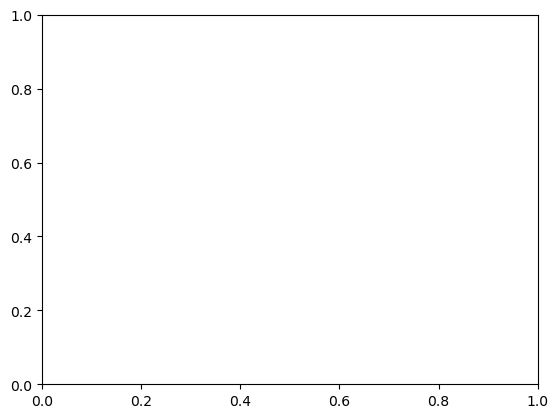

In [141]:
import sys
import importlib
sys.path.append('/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start')
from my_functions import *
del anim_singletime_var

plot_singletime_var(variable="Precac", timestamp="0000001200")
# Reload the module
importlib.reload(my_functions)

In [142]:
import matplotlib.animation as animation
def create_animation(variable: str, timesteps: list, duration: int = 20, output_file: str = "animation.mp4"):
    ims = []
    fig = None

    for timestamp in timesteps:
        if fig is None:
            fig = plot_singletime_var(variable, timestamp)
        else:
            fig = plot_singletime_var(variable, timestamp)
            plt.close(fig)

        im = fig.gca().get_images()[0]
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=(duration * 1000) / len(timesteps), blit=True)
    ani.save(output_file, writer='ffmpeg')

    plt.close(fig)


2


/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/my_functions.py:62: RuntimeWarning: divide by zero encountered in log
  # Apply logarithmic scaling for positive values


NameError: name 'LogNorm' is not defined

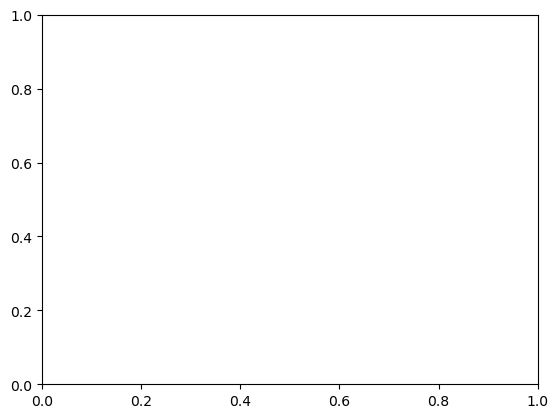

In [143]:
create_animation(variable="Precac", timesteps=["0000001200", "0000001440", "0000001680"], output_file="prec_testnew1.mp4")